# Building an LLM Router for High-Quality and Cost-Effective Responses

## TLDR
1. We introduce a framework for training state-of-the-art *LLM routers*, systems that dynamically direct queries to either high-quality closed LLMs or cost-effective open-source LLMs, based on query complexity, optimizing both response quality and cost.

2. This tutorial provides an in-depth guide on building an LLM router *based on a causal-LLM classifier*, starting with generating labeled data, finetuning an LLM-based classifier with Anyscale's API, and finally running offline evaluations.

3. In collaboration with the Berkeley LMSys group, we release an [arXiv paper](https://arxiv.org/pdf/2406.18665) presenting extensive evaluations of this model along with other models. Overall, our LLM Routers can achieve the same performance as our baselines with up to a 70% cost reduction on MT Bench, a 30% cost reduction on MMLU, and a 40% cost reduction on GSM8K.

# Background
When developing applications using Large Language Models (LLMs), achieving high-quality responses while maintaining a budget is a key challenge. Closed models like GPT-4 provide superior quality but are costly, especially with a high volume of queries. Conversely, Open Source Software (OSS) models are more economical but may not match the quality, especially for complex or domain-specific queries.

An **LLM Router** helps balance these aspects by deciding which queries are routed to a closed LLM and which to an OSS LLM based on the query's complexity or domain specificity. Below is a schematic representation of an LLM Router:

<div style="text-align: center;">
    <img src="assets/llm-router-flowchart_2.png" alt="LLM Router" width="800"/>
</div>

Given a set of user queries, an LLM router enables generating high-quality LLM responses while minimizing the overall cost.

# Approach

In this tutorial, we'll demonstrate how to train a *causal-LLM classifier* on the Anyscale platform as an effective LLM router. We make the following design choices:

1. **Model Choices**: We’ll use GPT-4 as an example of a closed LLM and Mixtral-8x7B as the OSS LLM, so our causal LLM classifier will route between these two models.
2. **Response Quality Rating**: We'll quantify the quality of an LLM response on a scale of 1 to 5 stars, with higher scores indicating better quality. For simplicity, we'll assume that GPT-4 always achieves a 5-star rating, so it serves as a reference for Mixtral-8x7B.
3. **Causal LLM Classifier**: We'll finetune a Llama3-8B model as our causal LLM classifier and leverage Anyscale's powerful API. [Our research](https://arxiv.org/pdf/2406.18665) shows that this model offers superior routing performance compared to smaller architectures.

More concretely, the objective of the causal LLM classifier is to direct "simple" queries to Mixtral-8x7B, thereby maintaining high overall response quality (e.g., an average score of 4.8/5) while significantly reducing costs (e.g., by 50%).

We show that it's possible to build LLM routers that achieve outstanding performance. Below are results from our best-performing LLM routers, the Causal LLM and a Matrix Factorization (MF) model, evaluated on the [MT Bench benchmark](https://arxiv.org/pdf/2306.05685), which demonstrate that our routers can achieve higher quality with lower costs (i.e., fewer calls to GPT-4) compared to the random baseline and public LLM routing systems from Unify AI and Martian. For more details on these results and additional ones, refer to our paper.

<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
    <img src="assets/indep-benchmarks.png" alt="Benchmark 1" style="width: 400px;"/>
    <img src="assets/indep-benchmarks-llama.png" alt="Benchmark 2" style="width: 400px;"/>
</div>

In the following sections, we discuss the steps that enable anyone to build a strong LLM router.


# Table of Contents

1. [**Prepare Labeled Data**](#generate-labeled-data): The foundation of a robust LLM router is high-quality labeled data. In this section, we'll guide you through preparing this training data.

2. [**Finetune a Router Model**](#finetune-router-model): We demonstrate how to finetune a causal-LLM classifier using Anyscale's finetuning API, transforming it into an effective LLM router.

3. [**Offline Evaluation**](#offline-eval): Using the public codebase ([RouteLLM](https://github.com/lm-sys/RouteLLM)), we will walk through an offline evaluation on standard benchmarks.

**Time to complete**: Approximately 120 minutes, including time to train on a node with 8xA10 GPUs.



### Setup

In [ ]:
# Install required packages
!pip install -r requirements.txt

# Store your ANYSCALE_API_KEY and OPENAI_API_KEY in /home/ray/default/.env
from dotenv import load_dotenv
load_dotenv("/home/ray/default/.env")


# Step 1: Prepare Labeled Data <a id="generate-labeled-data"></a>

The llm router essentially functions as a binary classifier, deciding whether to route a query to GPT-4 or Mixtral-8x7B based on the query text. Initially, we considered labeled data in the format `(query, routing_label)`, where `routing_label` is 1 if the query should be routed to Mixtral-8x7B and 0 if it should be routed to GPT-4.

However, our early experiments revealed that *binary labels do not provide sufficient signal for training a robust router model*. Therefore, we adopted a different labeling approach using a *1-5 scoring system*, which reflects how well Mixtral-8x7B can effectively respond to the user's query. More specifically:

- **4-5**: Mixtral-8x7B produces a very strong answer, showing deep understanding, creativity, detailed insight, and high relevance.
- **3**: Mixtral-8x7B provides an adequate answer with moderate detail, relevance, and factual accuracy.
- **1-2**: Mixtral-8x7B struggles to produce a strong answer due to the question's difficulty, vagueness, or the model's limitations.

We use labeled samples in the format `(query, score_label)`. The `routing_label` can be derived from the `score_label` by setting a score threshold for quality, i.e. `routing_label = 1 if score_label >= 4 else 0`.

Next, we'll dive into the detailed process of preparing our labeled dataset.


## 1.1: Query Dataset

We want our llm router to be effective in open-ended chat domains. So, our first step is to collect a set of generic queries from the [Nectar dataset](https://huggingface.co/datasets/berkeley-nest/Nectar). We chose the Nectar dataset for two reasons: it combines queries from many different domains, including open-ended chat, and it has responses from many models, including over 191K responses from GPT-4.

In [3]:
from src.utils import load_and_display_nectar

nectar_df = load_and_display_nectar()

,prompt,answers,turns,num_responses,source,good_natured
0,\n\nHuman: 0.002 = 1000 \n1 = x?\n\nAssistant:,"[{'answer': 'To find the value of x, we can set up a proportion using the given information: 0.002/1000 = 1/x To solve for x, we can cross multiply: 0.002 * x = 1000 * 1 0.002x = 1000 Dividing both sides by 0.002: x = 1000 / 0.002 x = 500,000 Therefore, 1 is equal to 500,000 in this proportion.', 'model': 'gpt-3.5-turbo', 'rank': 1.0}, {'answer': 'To solve for x in this equation, you can use cross-multiplication. Here's how: 0.002 / 1 = 1000 / x Cross-multiplication gives: 0.002 * x = 1000 To solve for x, divide both sides by 0.002: x = 1000 / 0.002 So, x equals 500,000.', 'model': 'gpt-4-0613', 'rank': 2.0}, {'answer': 'This looks like a proportion. To solve for x, you can set up a proportion equation: 0.002 / 1 = 1000 / x Now, cross-multiply: 0.002 \* x = 1 \* 1000 Then, solve for x: 0.002x = 1000 x = 1000 / 0.002 x = 500,000', 'model': 'gpt-3.5-turbo', 'rank': 3.0}, {'answer': 'If 0.002 equals 1000, then 1 would equal 500,000.', 'model': 'gpt-4', 'rank': 4.0}, {'answer': 'I apologize, but the equation you provided is not correct. 0.002 is equal to 0.002, not 1000. 1 is equal to x, not a number. Can you please provide a correct equation or problem for me to solve?', 'model': 'llama-2-7b-chat', 'rank': 5.0}, {'answer': '0.001 = x', 'model': 'gpt-3.5-turbo-instruct', 'rank': 6.0}, {'answer': 'It seems like you are asking for the value of x in the equation x = 1/0.002. To solve this equation, you can divide both sides by 0.002 to get: x = 1/0.002 x = 500 Therefore, x = 500.', 'model': 'mistral-7b-instruct-v0.1', 'rank': 7.0}]",1,7,[sharegpt],True


Number of queries with GPT-4 responses: 191487


## 1.2 Data Preprocessing

We will use a subset of the Nectar data that includes responses from GPT-4, as these will be used to generate scores (as seen below). We will process this data by focusing on single-turn conversations, filtering for good-natured interactions, and cleaning up the prompts and responses to maintain high quality. Additionally, we will sample a small subset from the dataset for the purpose of this tutorial; however, you can skip sampling to work with the full dataset.

In [4]:
from src.utils import preprocess_nectar

nectar_gpt4_df = preprocess_nectar(
    nectar_df, model="gpt-4", response_column="gpt4_response"
)

# Sample a small subset from the dataset for the purpose of this tutorial
N_SUBSET = 30
dataset_df = nectar_gpt4_df.sample(N_SUBSET, random_state=42)

### Dataset overview with GPT-4 responses

In [5]:
display(dataset_df.head())

,prompt,source,gpt4_response
6062,"Based on the features mentioned, which hotel d...",[evol_instruct],"Based on the features mentioned, Hotel A seems..."
113830,Provide step-by-step instructions on how to cr...,[ultrachat],"Sure, here's a simple step-by-step guide on ho..."
138869,What are the 10 largest cities in the US by po...,[lmsys-chat-1m],"As of the most recent data available, the 10 l..."
169249,Write a comparison essay of at least 500 words...,[ultrachat],Title: A Comparative Analysis of Driving a Car...
116934,"Q: You are provided with an ""Event"", ""Intent"" ...",[flan_v2_niv2],PersonX might feel satisfied or content using ...


## 1.3 Data Labeling

We don't have human labels for scores, so we will use the [LLM-as-a-Judge approach](https://arxiv.org/abs/2306.05685). GPT-4 will act as an evaluator, reviewing the query and Mixtral's response to provide a score from 1-5. As shown in the paper, the most robust way to get labels is by providing a reference answer for comparison. Here, GPT-4's own response serves as the reference, and Mixtral's response is evaluated against it.

There are two main steps in this process:
1. **Generate Mixtral-8x7B responses for all queries**: We will use an online batch-inference method utilizing Ray and Anyscale endpoints.
2. **Generate LLM-as-a-Judge labels**: We will ask GPT-4 to evaluate the Mixtral responses against its own reference answers and provide a score from 1-5.

### Generate Mixtral-8x7B Responses

In [7]:
import os
from src.online_inference import generate_mixtral_responses

dataset_df = generate_mixtral_responses(
    dataset_df, os.getenv("ANYSCALE_API_KEY"), response_column="mixtral_response"
)

Starting batch inference on 30 queries...
# queries un-processed: 29, in-progress: 1, ready: 0
# queries un-processed: 28, in-progress: 2, ready: 0
# queries un-processed: 27, in-progress: 2, ready: 1
# queries un-processed: 26, in-progress: 3, ready: 0
# queries un-processed: 25, in-progress: 4, ready: 0
# queries un-processed: 24, in-progress: 5, ready: 0
# queries un-processed: 23, in-progress: 6, ready: 0
# queries un-processed: 22, in-progress: 7, ready: 0
# queries un-processed: 21, in-progress: 8, ready: 0
# queries un-processed: 20, in-progress: 9, ready: 0
# queries un-processed: 19, in-progress: 10, ready: 0
# queries un-processed: 18, in-progress: 10, ready: 1
# queries un-processed: 17, in-progress: 11, ready: 0
# queries un-processed: 16, in-progress: 12, ready: 0
# queries un-processed: 15, in-progress: 13, ready: 0
# queries un-processed: 14, in-progress: 14, ready: 0
# queries un-processed: 13, in-progress: 14, ready: 1
# queries un-processed: 12, in-progress: 14, ready

### Dataset overview with Mixtral responses


In [8]:
display(dataset_df.head())

,prompt,source,gpt4_response,mixtral_response
6062,"Based on the features mentioned, which hotel d...",[evol_instruct],"Based on the features mentioned, Hotel A seems...","Based on the information provided, I would sa..."
113830,Provide step-by-step instructions on how to cr...,[ultrachat],"Sure, here's a simple step-by-step guide on ho...","Sure, I'd be happy to help you make a homemad..."
138869,What are the 10 largest cities in the US by po...,[lmsys-chat-1m],"As of the most recent data available, the 10 l...","Sure, I'd be happy to help with that! Here ar..."
169249,Write a comparison essay of at least 500 words...,[ultrachat],Title: A Comparative Analysis of Driving a Car...,Title: The Great Debate: Driving a Car vs. Ri...
116934,"Q: You are provided with an ""Event"", ""Intent"" ...",[flan_v2_niv2],PersonX might feel satisfied or content using ...,PersonX probably feels comfortable and focuse...


### Generate GPT-4-as-a-judge scores 

Let's first take a look at an example query we will send to GPT-4 for judgement

In [9]:
from src.utils import inspect_llm_judge_queries

inspect_llm_judge_queries(dataset_df)

[Instruction]
Evaluate the AI assistant's proficiency in answering the user question displayed below. Your evaluation should consider factors such as the helpfulness, relevance, adherence to real-world facts, depth, creativity, and level of detail of the response. You will be given a reference answer which is considered of high quality. Your assessment will have two lines: First line has a rating on a scale of 1 to 5 with a higher rating representing higher response quality. Follow strictly this format: "[[rating]]", for example: "[[3]]". Second line contains a short explanation of your rating.

[Question]
Q: You are provided with an "Event", "Intent" related to PersonX. Guess a reaction/reaction of PersonX about the given event and their intention.
Event:PersonX uses ___ in class. Intent: 1) to use his prefered writing implement
A:

[Reference Answer]
PersonX might feel satisfied or content using their preferred writing implement in class, as it aligns with their intention to utilize 

Now, we apply a similar online batch-inference method to generate our labels.

In [10]:
import os
from src.online_inference import generate_llm_judge_labels

dataset_df = generate_llm_judge_labels(dataset_df, os.getenv('OPENAI_API_KEY'))

Starting batch inference on 30 queries...
# queries un-processed: 29, in-progress: 1, ready: 0
# queries un-processed: 28, in-progress: 2, ready: 0
# queries un-processed: 27, in-progress: 3, ready: 0
# queries un-processed: 26, in-progress: 4, ready: 0
# queries un-processed: 25, in-progress: 5, ready: 0
# queries un-processed: 24, in-progress: 6, ready: 0
# queries un-processed: 23, in-progress: 6, ready: 1
# queries un-processed: 22, in-progress: 6, ready: 1
# queries un-processed: 21, in-progress: 7, ready: 0
# queries un-processed: 20, in-progress: 7, ready: 1
# queries un-processed: 19, in-progress: 7, ready: 1
# queries un-processed: 18, in-progress: 8, ready: 0
# queries un-processed: 17, in-progress: 9, ready: 0
# queries un-processed: 16, in-progress: 9, ready: 1
# queries un-processed: 15, in-progress: 9, ready: 1
# queries un-processed: 14, in-progress: 9, ready: 1
# queries un-processed: 13, in-progress: 10, ready: 0
# queries un-processed: 13, in-progress: 10, ready: 0
# 

### Dataset overview with score labels


In [11]:
display(dataset_df.head())

,prompt,source,gpt4_response,mixtral_response,mixtral_score
6062,"Based on the features mentioned, which hotel d...",[evol_instruct],"Based on the features mentioned, Hotel A seems...","Based on the information provided, I would sa...",5
113830,Provide step-by-step instructions on how to cr...,[ultrachat],"Sure, here's a simple step-by-step guide on ho...","Sure, I'd be happy to help you make a homemad...",3
138869,What are the 10 largest cities in the US by po...,[lmsys-chat-1m],"As of the most recent data available, the 10 l...","Sure, I'd be happy to help with that! Here ar...",5
169249,Write a comparison essay of at least 500 words...,[ultrachat],Title: A Comparative Analysis of Driving a Car...,Title: The Great Debate: Driving a Car vs. Ri...,4
116934,"Q: You are provided with an ""Event"", ""Intent"" ...",[flan_v2_niv2],PersonX might feel satisfied or content using ...,PersonX probably feels comfortable and focuse...,5


### Full Dataset
We have previously generated the full labeled datasets, created a train and validation splits, and published them as a public huggingface dataset `routellm/gpt4_dataset`. Let's load the dataset and explore the score distribution.


Train size: 109101


,prompt,source,gpt4_response,mixtral_response,mixtral_score
0,"I'll give you a review, can you extract the fo...",[lmsys-chat-1m],"Sure, here's the analysis of the review:\n\n1....",Food aspects and opinion words:\n\n1. Made to ...,4
1,"Answer the following question: Claim: ""Joker m...",[flan_v2_cot],The answer is no.\nChain of thoughts: Stan Lee...,The answer is no.\n\nChain of thoughts: While ...,5
2,TASK DEFINITION: In this task you will be give...,[flan_v2_niv2],ZdoublexpropheciesS,"ZdoublexpropheciesS\n\nIn this task, you are a...",5
3,"Detailed Instructions: In this task, you need ...",[flan_v2_niv2],Yes,"No, 'station' is not the longest word in the s...",5
4,A guy pick up a woman Then he puts her down Ex...,[sharegpt],This phrase could be interpreted as a joke bec...,This joke is a play on words and relies on the...,5


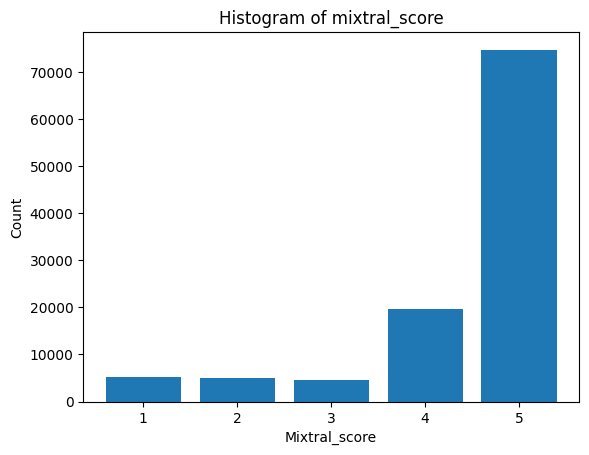

In [1]:
from datasets import load_dataset
from src.utils import visualize_label_distribution

full_dataset_df = load_dataset("routellm/gpt4_dataset")
train_df = full_dataset_df["train"].to_pandas()

print(f"Train size: {len(train_df)}")
display(train_df.head())
visualize_label_distribution(train_df, key="mixtral_score")

Higher counts for 4-5 scores indicate that Mixtral-8x7B consistently produces high-quality responses, demonstrating its competitive performance compared to the June 2023 version of GPT-4, whose responses are logged in the Nectar dataset.

Let us assume that if the score is >= 4, we will route to the OSS model (indicating the response quality is good enough); otherwise, we will route to the closed model. Under this assumption, the data distribution looks like this:


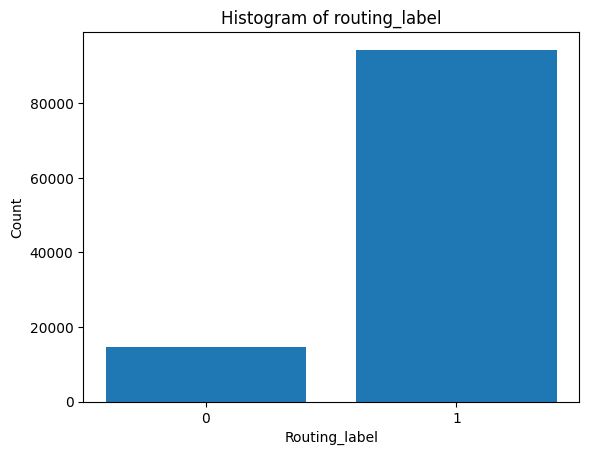

In [2]:
train_df["routing_label"] = train_df["mixtral_score"].apply(
    lambda x: 1 if x >= 4 else 0
)

visualize_label_distribution(train_df, key="routing_label")

# Step 2: Finetune a router model <a id="finetune-router-model"></a>

In this section, we will explain how to finetune a causal LLM classifier to be an effective router. While our data contains `gpt4_response` and `mixtral_response`, we will only use the pair (`query`, `mixtral_score`) for training. The goal is for the router to rely solely on the query text to determine which model to route to. Our approach is straightforward: we train a 5-way classifier to predict the `mixtral_score` from the `query`. At inference time, we will route to Mixtral if our router predicts a high score (i.e., 4-5) and to GPT-4 otherwise.


## 2.1 Data Preparation
We will discuss a few preprocessing steps to prepare the data for finetuning an LLM classifier.

### Task Instructions
We use the instruction-following framework to finetune an LLM as a router. The task instructions guide the model to predict the score label for a given query. They ensure the model understands the evaluation criteria and can accurately assess the query's complexity and expected response quality.

In [3]:
from src.utils import inspect_instructions

inspect_instructions()

[Instruction]
Based on the question provided below, predict the score an expert evaluator would give to an AI assistant's response, considering its helpfulness, relevance, adherence to facts, depth, creativity, and detail. Your prediction should infer the level of proficiency needed to address the question effectively. Use a scale from 1 to 5, where a higher score indicates a higher anticipated quality of response. Provide your prediction as: "[[predicted rating]]".

Score criteria:
- **4-5**: The AI assistant can produce a very strong answer, showing deep understanding, creativity, detailed insight, and high relevance.
- **3**: The AI assistant can provide an adequate answer with moderate detail, relevance, and factual accuracy.
- **1-2**: The AI assistant will struggle to produce a strong answer due to the question's difficulty, vagueness, or the assistant's limitations.

[Question]
{question}

Prediction:



### API Data Format

To finetune the model, we must format the data to be compatible with [Anyscale's finetuning API](https://docs.anyscale.com/endpoints/fine-tuning/dataset-prep).


In [4]:
from src.utils import prepare_ft_messages

train_df["messages"] = prepare_ft_messages(train_df, "mixtral_score")

# here's what the API data format looks like:
display(train_df["messages"].iloc[0])

[{'role': 'system',
  'content': '[Instruction]\nBased on the question provided below, predict the score an expert evaluator would give to an AI assistant\'s response, considering its helpfulness, relevance, adherence to facts, depth, creativity, and detail. Your prediction should infer the level of proficiency needed to address the question effectively. Use a scale from 1 to 5, where a higher score indicates a higher anticipated quality of response. Provide your prediction as: "[[predicted rating]]".\n\nScore criteria:\n- **4-5**: The AI assistant can produce a very strong answer, showing deep understanding, creativity, detailed insight, and high relevance.\n- **3**: The AI assistant can provide an adequate answer with moderate detail, relevance, and factual accuracy.\n- **1-2**: The AI assistant will struggle to produce a strong answer due to the question\'s difficulty, vagueness, or the assistant\'s limitations.\n'},
 {'role': 'user',
  'content': "[Question]\nI'll give you a review

### Label Rebalancing

For classification tasks, it's recommended to train on label-balanced datasets to ensure models are not biased to a specific label. We will balance the dataset based on `routing_label`, as this is the label of primary interest.


In [5]:
from src.utils import balance_dataset

balanced_train_df = balance_dataset(train_df, key="routing_label")

print(f"Train size: {len(balanced_train_df)}")

Train size: 29504


### Subsample and Store Data

To expedite the time to run this tutorial, we will subsample 1,000 examples for training. We'll store the data in JSONL format to prepare for launching the finetuning job in the next section.

In [6]:
n_sample = 1000
output_file = "/mnt/user_storage/train_data_sample.jsonl"

subsampled_df = balanced_train_df.sample(n=n_sample, random_state=42)
subsampled_df.to_json(output_file, orient="records", lines=True)

## 2.2 Fine-tune with Anyscale API

We will run a fine-tuning job using Anyscale's LLM finetuning API as an isolated job, similar to our [end-to-end LLM workflows guide](https://github.com/anyscale/e2e-llm-workflows?tab=readme-ov-file#fine-tuning-1).

For this tutorial, we will perform full-parameter finetuning of Llama3-8B on the same 1,000 samples we showed earlier to debug the training dynamics and ensure the model can fit the training set. Below, we present the training and job configurations before submitting the training job.


In [19]:
# View the full-param finetuning configuration for llama-3-8B
!cat configs/ft_config_a10.yaml

model_id: meta-llama/Meta-Llama-3-8B
train_path: /mnt/user_storage/train_data_sample.jsonl
valid_path: /mnt/user_storage/train_data_sample.jsonl
context_length: 1024
num_devices: 8
num_epochs: 5
checkpoint_every_n_epochs: 5
train_batch_size_per_device: 4
eval_batch_size_per_device: 4
lr_scheduler_type: constant
learning_rate: 1e-5
num_checkpoints_to_keep: 1
no_gradient_checkpoint: False
output_dir: /mnt/local_storage
deepspeed:
  config_path: config_files/deepspeed/zero_3_optimizer_parameter_offload.json
flash_attention_2: true
classifier_config:
  label_tokens:
      - "[[1]]"
      - "[[2]]"
      - "[[3]]"
      - "[[4]]"
      - "[[5]]"


In [20]:
# View job yaml config
!cat configs/ft_job.yaml

name: llm-router-tutorial
entrypoint: python src/ft.py configs/ft_config_a10.yaml
image_uri: localhost:5555/anyscale/llm-forge:0.5.0.0
requirements: requirements.txt
max_retries: 0


In [21]:
# Job submission
!anyscale job submit --config-file configs/ft_job.yaml --exclude assets

Output
(anyscale +1.0s) Submitting job with config JobConfig(name='llm-router-tutorial', image_uri='localhost:5555/anyscale/llm-forge:0.5.0.0', compute_config=None, env_vars=None, py_modules=None, cloud=None, project=None, ray_version=None).
(anyscale +2.1s) Uploading local dir '.' to cloud storage.
(anyscale +3.2s) Job 'llm-router-tutorial' submitted, ID: 'prodjob_cj7ek1pc72672hq1htqg17ca15'.
(anyscale +3.2s) View the job in the UI: https://console.anyscale.com/jobs/prodjob_cj7ek1pc72672hq1htqg17ca15
(anyscale +3.2s) Use `--wait` to wait for the job to run and stream logs.


The job takes around 10 minutes on `4xA100-80gb` and 1 hour on `8xA10-22gb` to finish. Training logs will show the final model checkpoint, e.g.:

```
Best checkpoint is stored in:
storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/amjad__almahairi_dkaubsimoyxpiksqxqkxrfgfvzzotwtacs/llmforge-finetuning/meta-llama/Meta-Llama-3-8B/TorchTrainer_2024-06-21_17-02-52/epoch-4
With perplexity: 1.0318867739521242
```
This checkpoint can be used to run batch inference or serve the model online.

# Step 3: Offline Evaluation <a id="offline-eval"></a>

Next, we will conduct an offline evaluation of the model trained on an out-of-domain dataset. The same model, now trained on the full dataset, is available in the following GitHub repository: [https://github.com/lm-sys/RouteLLM/](https://github.com/lm-sys/RouteLLM/), along with other router models.


### Install `RouteLLM` package

In [ ]:
# Clone the repository under /home/ray/default/
!git clone https://github.com/lm-sys/RouteLLM.git /home/ray/default/RouteLLM

# Change to the cloned repository directory
%cd /home/ray/default/RouteLLM

# Install the package with the specified extras
!pip install -e .[eval]

### Inference Example
Let's show an example of loading the model and running inference with a single example sampled from our data. Note that you need to get access to `meta-llama/Meta-Llama-3-8B` in order to run these evaluations.  Let's first show how a formatted input looks like.

In [23]:
# Store your `meta-llama` access token in /home/ray/default/.env with the name LLAMA2_HF_TOKEN
from dotenv import load_dotenv
load_dotenv("/home/ray/default/.env")

from pprint import pprint

# Sample one row from the DataFrame
sampled_row = train_df.sample(n=1, random_state=42)

# Convert the sampled row to a dictionary without the index
input_example = sampled_row.to_dict(orient='records')[0]

print("Prompt:", input_example['prompt'])
print("Label:", input_example['mixtral_score'])
print("Messages:")
pprint(input_example['messages'])

Prompt: What challenges did FDR face while in office
Label: 5
Messages:
[{'content': '[Instruction]\n'
             'Based on the question provided below, predict the score an '
             "expert evaluator would give to an AI assistant's response, "
             'considering its helpfulness, relevance, adherence to facts, '
             'depth, creativity, and detail. Your prediction should infer the '
             'level of proficiency needed to address the question effectively. '
             'Use a scale from 1 to 5, where a higher score indicates a higher '
             'anticipated quality of response. Provide your prediction as: '
             '"[[predicted rating]]".\n'
             '\n'
             'Score criteria:\n'
             '- **4-5**: The AI assistant can produce a very strong answer, '
             'showing deep understanding, creativity, detailed insight, and '
             'high relevance.\n'
             '- **3**: The AI assistant can provide an adequate answer 

Let's run inference with this example and examine the model's output.

In [25]:
from src.offline_inference import single_example_inference

result = single_example_inference(input_example)
pprint(result)

Loading model checkpoint from routellm/causal_llm_gpt4_augmented ...


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Done loading model in 5.628355264663696 seconds.
{'binary_prob': 0.9662781,
 'output_ids': tensor([128006,  78191, 128007,    271, 128260, 128009]),
 'output_str': '<|start_header_id|>assistant<|end_header_id|>\n'
               '\n'
               '[[5]]<|eot_id|>',
 'output_tokens': ['<|start_header_id|>',
                   'assistant',
                   '<|end_header_id|>',
                   'ĊĊ',
                   '[[5]]',
                   '<|eot_id|>'],
 'score_logits': array([10.3125, 10.9375, 11.4375, 14.4375, 15.    ], dtype=float32),
 'score_pred': 5,
 'softmax_scores': array([0.00566901, 0.0105911 , 0.01746178, 0.3507292 , 0.6155489 ],
      dtype=float32)}


The model outputs the predicted score as a special token`[[5]]`, since it is trained to predict one of the 5 labels which we add as special tokens to the vocabulary. We extract softmax scores of each of 5 labels in `softmax_scores`, and compute the routing probability as `binary_prob = sum(softmax_scores[3:])`.

To optimize inference speed, we can append the header tokens `<|start_header_id|>assistant<|end_header_id|>\n\n`  so the first token that the model outputs is the predicted label.

### Benchmark Evaluation
We will use the RouteLLM evaluation framework to measure the performance of our router against a random router on GSM8K. 
We report the percentage of calls the router needs to send to GPT-4 in order to achieve `20%`, `50%` and `80%` of GPT-4 performance, along with area under curve. 
See our [paper](https://arxiv.org/pdf/2406.18665) for more details on the evalaution metrics.

In [13]:
!python -m routellm.evals.evaluate --config config.example.yaml --routers random causal_llm --benchmark gsm8k

Namespace(routers=['random', 'causal_llm'], benchmark='gsm8k', output='.', overwrite_cache=[], parallel=96, config='config.example.yaml', num_results=10)
INFO: Pandarallel will run on 96 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Running eval for GSM8k.
1307/1319 questions for GSM8K after decontamination.
Evaluating router: random with threshold 0.00024069652516689466...

=============== random with threshold 0.00024069652516689466 on gsm8k ===============
Average accuracy: 85.769
Model counts: gpt-4-1106-preview: 1307
Model %: gpt-4-1106-preview: 100.000%

Evaluating router: random with threshold 0.07792316246593108...

=============== random with threshold 0.07792316246593108 on gsm8k ===============
Average accuracy: 83.168
Model counts: gpt-4-1106-preview: 1176, mistralai/Mixtral-8x7B-Instruct-v0.1: 131
Model %: gpt-4-1106-preview: 89.977%, mistralai/Mixtral-8x7B-Instruct-v0.1: 10.023%

Evaluating router: random wit

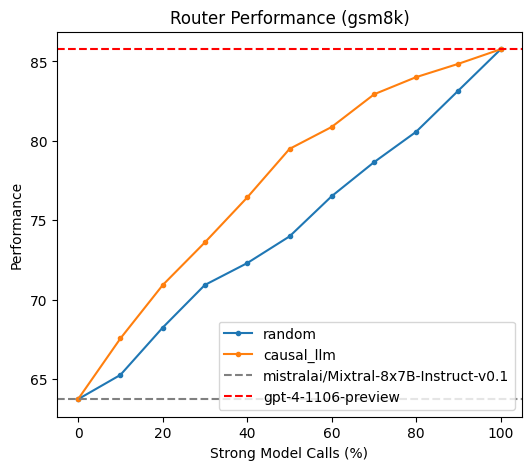

In [14]:
from IPython.display import Image, display

# Display full plot saved in the following path
image_path = "/home/ray/default/RouteLLM/gsm8k.png"
display(Image(filename=image_path))

This plot illustrates that as we relax the cost constraints (i.e., increase the percentage of GPT-4 calls), the performance improves. While the performance of a random router improves linearly with cost, our router achieves significantly better results at each cost level.

# Conclusion
In this tutorial, we have successfully built and evaluated a finetuned-LLM router. We generated synthetic labeled data using the LLM-as-a-judge method to train the model, finetuned an LLM classifier using Anyscale's API, and conducted offline evaluation on a standard benchmark-- demonstrating that our model is effective in out-of-domain generalization.